# NYPD ARREST DATA

# The NYPD just arrested a person. You are told the gender, age an race of the person and location of crime. Can you predict the type of crime the person  committed with accuracy and precision?

We are going to create a supervised machine learning algorithm to predict the level of crime(felony, misdemeanor, violation or infraction) accurately.

First, we will load the data, then clean it, and explore it and along the way get it ready for the classification task.

# Loading Data

In [1]:
#Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
font = {'family': 'serif','color':  'darkred','weight': 'normal','size': 16}
import seaborn as sns
import pandas as pd
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
pwd

'/Users/jja/GitHub/NYPD_Arrest_Analysis'

In [137]:
#Load in the data
data = pd.read_csv('/Users/jja/GitHub/NYPD_Arrest_Data__Year_to_Date_.csv')
#Look at five rows
data.head(5)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,206892169,12/31/2019,907.0,"IMPAIRED DRIVING,DRUG",347.0,INTOXICATED & IMPAIRED DRIVING,VTL11920U4,M,M,33,0,25-44,M,WHITE,1000916,245710,40.841085,-73.939769
1,206888084,12/31/2019,739.0,"FRAUD,UNCLASSIFIED-FELONY",112.0,THEFT-FRAUD,PL 1908301,F,Q,101,0,25-44,M,BLACK HISPANIC,1055868,156522,40.596012,-73.742116
2,206890433,12/31/2019,122.0,"HOMICIDE, NEGLIGENT, VEHICLE,",102.0,HOMICIDE-NEGLIGENT-VEHICLE,PL 1251201,F,M,23,0,18-24,M,BLACK,997462,227024,40.789803,-73.952289
3,206890441,12/31/2019,268.0,CRIMINAL MIS 2 & 3,121.0,CRIMINAL MISCHIEF & RELATED OF,PL 1450502,F,S,120,0,18-24,M,BLACK,962822,174282,40.645023,-74.077217
4,206890973,12/31/2019,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,25,97,25-44,M,BLACK,1004138,226326,40.787875,-73.928182


In [138]:
#Look at the columns and rows
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214617 entries, 0 to 214616
Data columns (total 18 columns):
ARREST_KEY           214617 non-null int64
ARREST_DATE          214617 non-null object
PD_CD                214576 non-null float64
PD_DESC              214458 non-null object
KY_CD                214458 non-null float64
OFNS_DESC            214458 non-null object
LAW_CODE             214617 non-null object
LAW_CAT_CD           213248 non-null object
ARREST_BORO          214617 non-null object
ARREST_PRECINCT      214617 non-null int64
JURISDICTION_CODE    214617 non-null int64
AGE_GROUP            214617 non-null object
PERP_SEX             214617 non-null object
PERP_RACE            214617 non-null object
X_COORD_CD           214617 non-null int64
Y_COORD_CD           214617 non-null int64
Latitude             214617 non-null float64
Longitude            214617 non-null float64
dtypes: float64(4), int64(5), object(9)
memory usage: 29.5+ MB


# The Data Dictionary

In [139]:
#The Data Dictionary for the Columns obtained from the NYPD Website
data_dictionary = """
ARREST_KEY: Randomly generated persistent ID for each arrest

ARREST_DATE: Exact date of arrest for the reported event

PD_CD: Three digit internal classification code (more granular than
Key Code)

PD_DESC: Description of internal classification corresponding with PD
code (more granular than Offense Description)

KY_CD: Three digit internal classification code (more general
category than PD code)

OFNS_DESC: Description of internal classification corresponding with KY
code (more general category than PD description)

LAW_CODE: Law code charges corresponding to the NYS Penal Law,
VTL and other various local laws

LAW_CAT_CD: Level of offense: felony, misdemeanor, violation

ARREST_BORO: Borough of arrest. B(Bronx), S(Staten Island), K(Brooklyn),
M(Manhattan), Q(Queens)

ARREST_PRECINCT: Precinct where the arrest occurred

JURISDICTION_CODE: Jurisdiction responsible for arrest. Jurisdiction codes
0(Patrol), 1(Transit) and 2(Housing) represent NYPD whilst
codes 3 and more represent non NYPD jurisdictions

AGE_GROUP: Perpetrator’s age within a category

PERP_SEX: Perpetrator’s sex description

PERP_RACE: Perpetrator’s race description

X_COORD_CD: Midblock X-coordinate for New York State Plane
Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)

Y_COORD_CD: Midblock Y-coordinate for New York State Plane
Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)

Latitude: Latitude coordinate for Global Coordinate System, WGS
1984, decimal degrees (EPSG 4326)

Longitude: Longitude coordinate for Global Coordinate System, WGS
1984, decimal degrees (EPSG 4326)

"""

# Preprocess Data

In [140]:
#change borough columns to make it clear
borough= {'K': 'Brooklyn', 'M': 'Manhattan','B':'Bronx','Q':"Queens", 'S':'Staten Island'}
#change the crime labels to make it clear
crimes = {'M': 'Misdemeanor', 'F':'Felony', 'V':'Violation' ,'I':'Infraction'}
#change the gender labels
gender = {'M': 'Male', 'F':'Female'}
#Replace borough label
data['ARREST_BORO'] = data['ARREST_BORO'].replace(borough)
#Replace Crime label
data['LAW_CAT_CD'] = data['LAW_CAT_CD'].replace(crimes)
#Replace gender label
data['PERP_SEX'] =  data['PERP_SEX'].replace(gender)
# Change the column names
data.rename(columns={'PD_DESC':'OFFENSE_DESC_1', 'OFNS_DESC':'OFFENSE_DESC_2' ,'LAW_CAT_CD':'LEVEL_OF_OFFENSE','PD_CD':'INTERNAL_CODE_1','KY_CD':'INTERNAL_CODE_2'}, inplace=True)

In [141]:
#Look at the unique values for each column with less than 20 unique values
for column in data.columns:
    if len(data[column].unique()) <20:
        print(column,':',data[column].unique())

LEVEL_OF_OFFENSE : ['Misdemeanor' 'Felony' 'Violation' 'Infraction' nan]
ARREST_BORO : ['Manhattan' 'Queens' 'Staten Island' 'Brooklyn' 'Bronx']
AGE_GROUP : ['25-44' '18-24' '45-64' '<18' '65+']
PERP_SEX : ['Male' 'Female']
PERP_RACE : ['WHITE' 'BLACK HISPANIC' 'BLACK' 'WHITE HISPANIC' 'UNKNOWN'
 'ASIAN / PACIFIC ISLANDER' 'AMERICAN INDIAN/ALASKAN NATIVE']


The above categorical values are found in the data. The LAW_CAT_CD is type of crime indicator (dictionary above) that lists felony, misdemeanor, violation, etc. The others are Borough (ARREST_BORO), age group (AGE_GROUP), gender (PERP_SEX), and race (PERP_RACE).

Let me look at columns that have more than 20 unique values next.
Because the dataframe is 214617 rows long (as seen in the output from data.info()), I am going to keep any column with unique features that are under 1000 in number. Even though 1000 is a big number, it is much smaller than ~200,000. To be exact, it is half a percent.

In [142]:
#Look at the unique values for columns containing greater than 20 values
#We don't want TOO MUCH variability because easier to cause overfitting
for column in data.columns:
    print(column,'unique values:',len(data[column].unique()))

ARREST_KEY unique values: 214617
ARREST_DATE unique values: 365
INTERNAL_CODE_1 unique values: 274
OFFENSE_DESC_1 unique values: 260
INTERNAL_CODE_2 unique values: 70
OFFENSE_DESC_2 unique values: 66
LAW_CODE unique values: 1144
LEVEL_OF_OFFENSE unique values: 5
ARREST_BORO unique values: 5
ARREST_PRECINCT unique values: 77
JURISDICTION_CODE unique values: 25
AGE_GROUP unique values: 5
PERP_SEX unique values: 2
PERP_RACE unique values: 7
X_COORD_CD unique values: 30379
Y_COORD_CD unique values: 32192
Latitude unique values: 38443
Longitude unique values: 38452


In [143]:
data.INTERNAL_CODE_2.unique()

array([347., 112., 102., 121., 344., 233., 117., 359., 126., 107., 341.,
       351., 348., 105., 106., 236., 118., 352., 125., 235., 881., 109.,
       340., 101., 358., 675., 361., 113., 363., 111., 116., 110., 353.,
       343., 120., 104., 232., 677., 364., 119., 678., 103., 238., 231.,
       114., 355., 346., 350., 115., 356., 995., 880., 572., 365.,  nan,
       124., 122., 354., 578., 345., 234., 230., 685., 349., 360., 676.,
       571., 237., 455., 882.])

In [144]:
#Based on the above unique counts, I will select the following columns to drop 
#because they are not useful features to train a classifier.
drop_following = """
Columns to drop:

ARREST_KEY: this is a unique identifier used internally by the NYPD. It serves no purpose here.
ARREST_DATE: WE will drop this and bin it into to Month
X_COORD_CD: Not using coordinates in logistic regression
Y_COORD_CD: Not using coordinates in logistic regression
Latitude: Not using coordinates
Longitude: Not using coordinates

"""

In [145]:
#Drop the columns that wont provide informational value
data.drop(['ARREST_KEY', 'Latitude','Longitude','ARREST_DATE'], axis=1, inplace=True)

In [146]:
#How many empty values are there in each column?
data.isnull().sum()

INTERNAL_CODE_1        41
OFFENSE_DESC_1        159
INTERNAL_CODE_2       159
OFFENSE_DESC_2        159
LAW_CODE                0
LEVEL_OF_OFFENSE     1369
ARREST_BORO             0
ARREST_PRECINCT         0
JURISDICTION_CODE       0
AGE_GROUP               0
PERP_SEX                0
PERP_RACE               0
X_COORD_CD              0
Y_COORD_CD              0
dtype: int64

In [147]:
#Because there are not that many nulls, won't worry about them, just going to drop them
data.dropna(inplace=True)

In [148]:
# data['ARREST_DATE'] = pd.to_datetime(data['ARREST_DATE'], format = "%m/%d/%Y")

In [149]:
#Create a catagoric column for month
#Use a function to convert the date into a month category. 
# Then use one-hot encoding to convert the months into twelve variables 

Now that the data is ready, we will proceed with exploring the columns

# Borough

Text(0, 0.5, 'Number of Arrested')

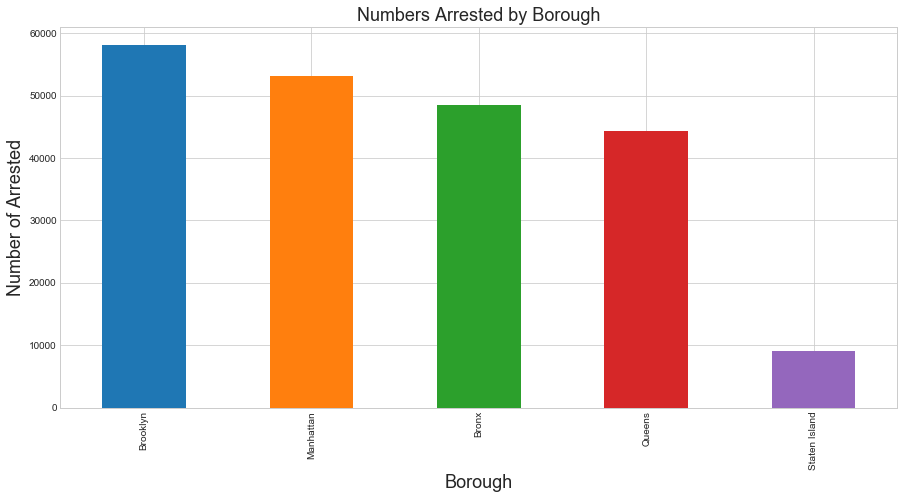

In [150]:
#Number of arrests by Borough
arrest_by_boro = data.groupby('ARREST_BORO').ARREST_BORO.count()
arrest_by_boro = pd.DataFrame(arrest_by_boro.sort_values(ascending = False))
#Plot race of arrested
plt.style.use('seaborn-whitegrid')
fig = plt.figure(num=None, figsize=(15, 7))
ax = plt.axes()
ax = data.ARREST_BORO.value_counts(sort=True).plot(kind='bar')
ax.set_title('Numbers Arrested by Borough',fontsize=18)
ax.set_xlabel("Borough",fontsize=18)
ax.set_ylabel("Number of Arrested",fontsize=18)

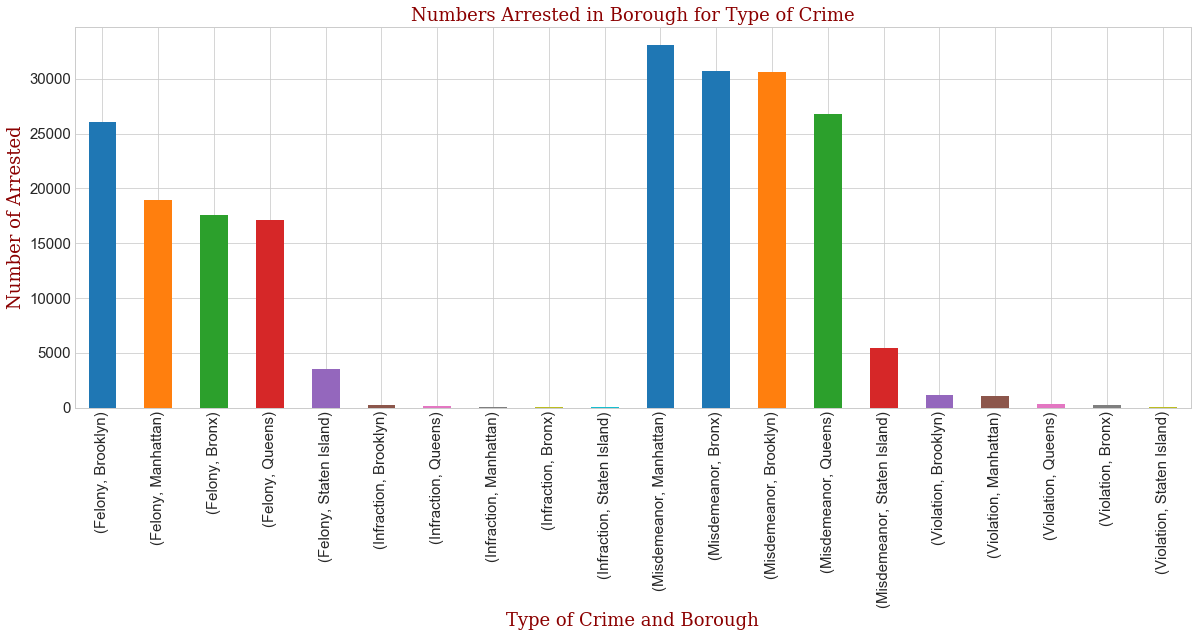

In [151]:
#Looking at the types of arrests by Borough
fig = plt.figure(num=None, figsize=(20, 7))
ax = plt.axes()
ax = data.groupby('LEVEL_OF_OFFENSE')['ARREST_BORO'].value_counts(sort=True).plot(kind='bar',)
ax.set_title('Numbers Arrested in Borough for Type of Crime',fontsize=18,fontdict=font)
ax.set_xlabel("Type of Crime and Borough",fontsize=18,fontdict=font)
ax.set_ylabel("Number of Arrested",fontsize=18,fontdict=font)
ax.tick_params(labelsize=15)

Brooklyn has the most felonies.

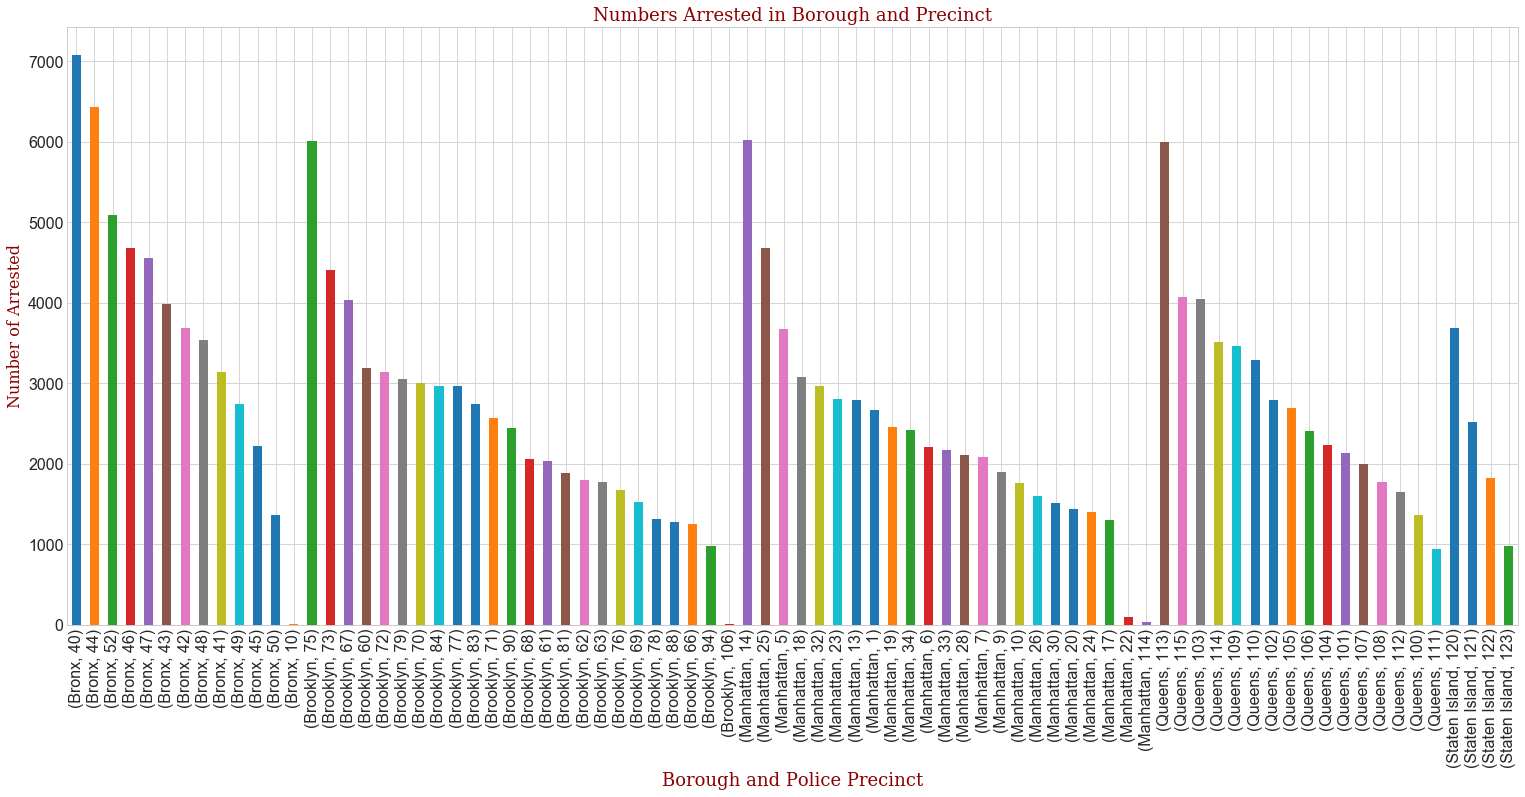

In [152]:
#Arrests by Boro Precinct
font = {'family': 'serif','color':  'darkred','weight': 'normal','size': 16}
fig = plt.figure(num=None, figsize=(26, 11))
ax = plt.axes()
ax = data.groupby('ARREST_BORO').ARREST_PRECINCT.value_counts(sort=True).plot(kind='bar')
ax.set_title('Numbers Arrested in Borough and Precinct',fontsize=18,fontdict=font)
ax.set_xlabel("Borough and Police Precinct",fontsize=18,fontdict=font)
ax.set_ylabel("Number of Arrested",fontdict=font)
ax.tick_params(labelsize=16)

# Age

We see below a majority of arrested persons are between 25 and 44.

In [153]:
#Age Group of Arrested
counts = data.AGE_GROUP.value_counts()
percent = data.AGE_GROUP.value_counts(normalize = True).mul(100).round(2).astype(str) + '%'
pd.DataFrame({'Counts': counts, 'Percent': percent})

,Counts,Percent
25-44,113292,53.17%
18-24,43275,20.31%
45-64,43249,20.3%
<18,10260,4.81%
65+,3013,1.41%


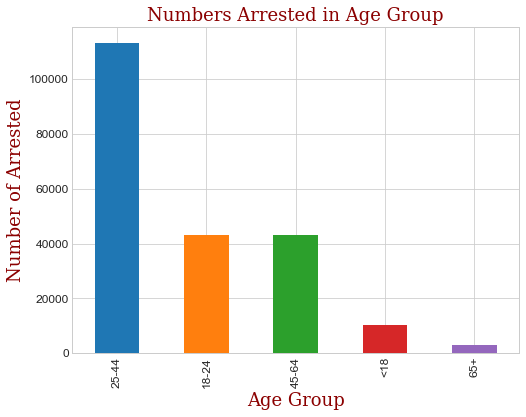

In [154]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(8, 6))
ax = plt.axes()
ax = data.AGE_GROUP.value_counts(sort=True).plot(kind='bar')
ax.set_title('Numbers Arrested in Age Group',fontsize=18,fontdict=font)
ax.set_xlabel("Age Group",fontsize=18,fontdict=font)
ax.set_ylabel("Number of Arrested",fontsize=18,fontdict=font)
ax.tick_params(labelsize=12)

# Race

Race is an important feature for this project. One of the main attempts of our classification tasks is to see if we can predict race from the other arrest features. Doing this will allow us to know if there are distinct characteristics to a crime that may indicate a person's race.

In [155]:
#Race of Arrested
counts = data.PERP_RACE.value_counts()
percent = data.PERP_RACE.value_counts(normalize = True).mul(100).round(2).astype(str) + '%'
pd.DataFrame({'Counts': counts, 'Percent': percent})

,Counts,Percent
BLACK,101979,47.86%
WHITE HISPANIC,53265,25.0%
WHITE,25284,11.87%
BLACK HISPANIC,18550,8.71%
ASIAN / PACIFIC ISLANDER,12013,5.64%
UNKNOWN,1401,0.66%
AMERICAN INDIAN/ALASKAN NATIVE,597,0.28%


Text(0, 0.5, 'Number of Arrested')

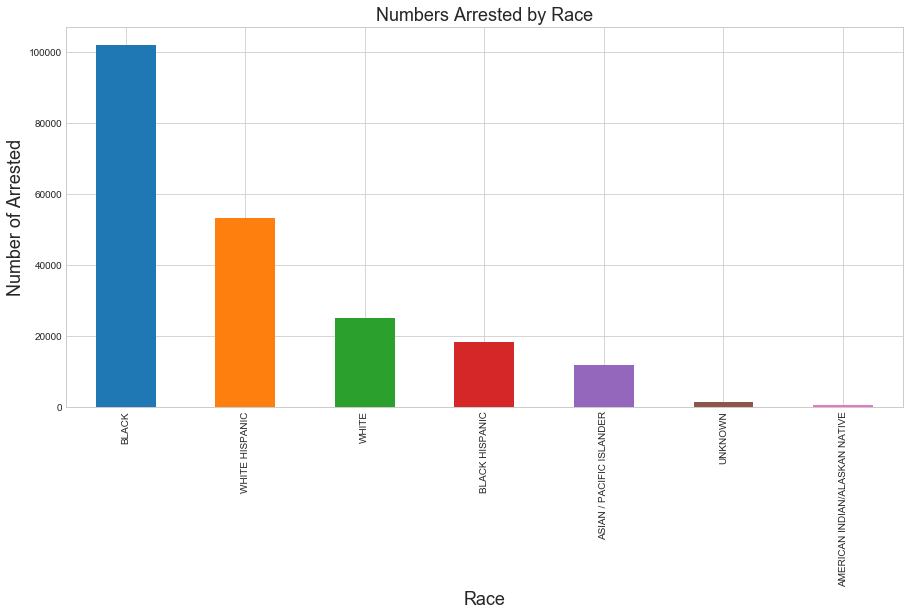

In [156]:
#Plot race of arrested
plt.style.use('seaborn-whitegrid')
fig = plt.figure(num=None, figsize=(15, 7))
ax = plt.axes()
ax = data.PERP_RACE.value_counts(sort =True).plot(kind='bar')
ax.set_title('Numbers Arrested by Race',fontsize=18)
ax.set_xlabel("Race",fontsize=18)
ax.set_ylabel("Number of Arrested",fontsize=18)

Black persons are just under 50% of those arrested. If we add Black Hispanic, then black people make up a majority of arrests.

# Race and Age

In [123]:
#Races of the Arrested by Age Group
counts = data.groupby('AGE_GROUP').PERP_RACE.value_counts(sort=True)
# pd.DataFrame({'Counts': counts})

Most of those arrested are between 25 to 44. 

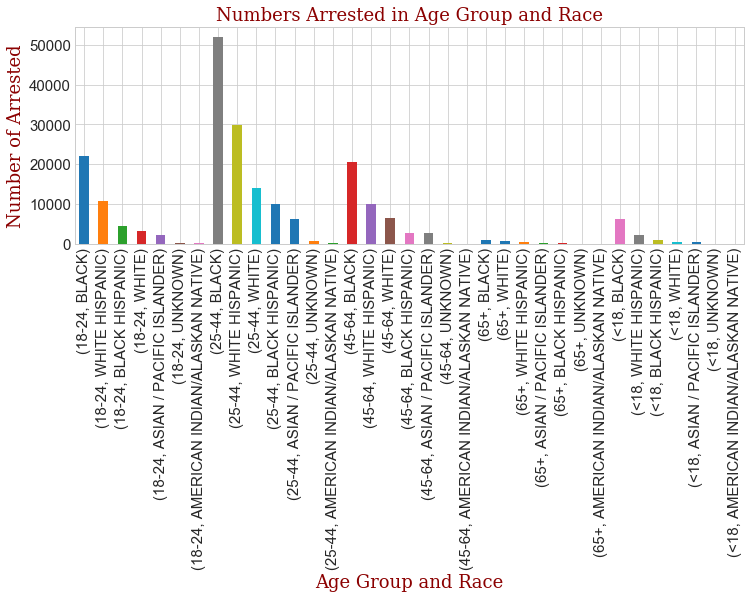

In [124]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(num=None, figsize=(12, 4))
ax = plt.axes()
ax = data.groupby('AGE_GROUP').PERP_RACE.value_counts(sort=True).plot(kind='bar')
ax.set_title('Numbers Arrested in Age Group and Race',fontsize=18,fontdict=font)
ax.set_xlabel("Age Group and Race",fontsize=18,fontdict=font)
ax.set_ylabel("Number of Arrested",fontsize=18,fontdict=font)
ax.tick_params(labelsize=15)

It looks from the shape of the above graphs that every race has the same pattern of arrests by age group. So every race behaves the same across age.

# Gender

Below we see that 81.64% of those arrested are men

In [125]:
#Male vs Female
counts = data.PERP_SEX.value_counts()
percent = data.PERP_SEX.value_counts(normalize = True).mul(100).round(2).astype(str) + '%'
pd.DataFrame({'Counts': counts, 'Percent':percent})

,Counts,Percent
Male,173964,81.64%
Female,39125,18.36%


# Gender and Race

What is the relationship between gender and race?

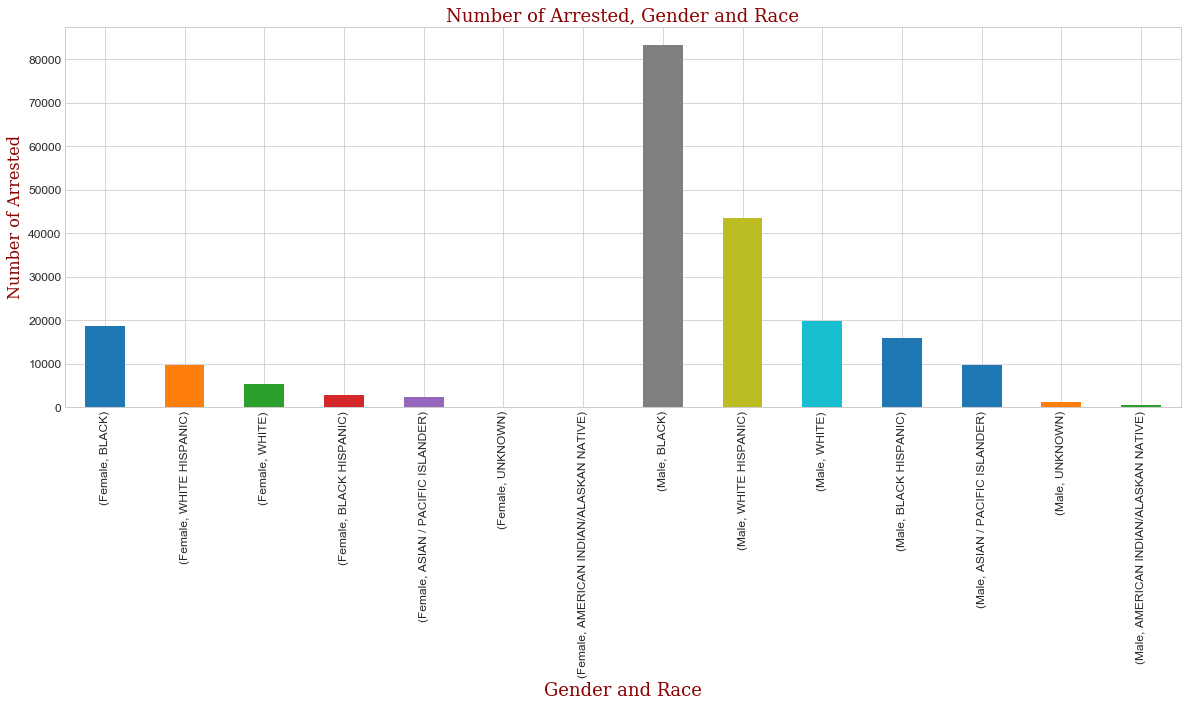

In [126]:
#Arrests by Gender and Race
font = {'family': 'serif','color':  'darkred','weight': 'normal','size': 16}
fig = plt.figure(num=None, figsize=(20, 7))
ax = plt.axes()
ax = data.groupby('PERP_SEX').PERP_RACE.value_counts(sort=True).plot(kind='bar')
ax.set_title('Number of Arrested, Gender and Race',fontsize=18,fontdict=font)
ax.set_xlabel("Gender and Race",fontsize=18,fontdict=font)
ax.set_ylabel("Number of Arrested",fontdict=font)
ax.tick_params(labelsize=12)

Black males make up the largest portion of those arrested. The number of arrested males of each race is more than its female counterparts: Males are more criminal in general.

# Classification Models

In [157]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

In [158]:
#Look at the data columns again
data.columns

Index(['INTERNAL_CODE_1', 'OFFENSE_DESC_1', 'INTERNAL_CODE_2',
       'OFFENSE_DESC_2', 'LAW_CODE', 'LEVEL_OF_OFFENSE', 'ARREST_BORO',
       'ARREST_PRECINCT', 'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX',
       'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD'],
      dtype='object')

In [159]:
#Look at the data types again
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213089 entries, 0 to 214616
Data columns (total 14 columns):
INTERNAL_CODE_1      213089 non-null float64
OFFENSE_DESC_1       213089 non-null object
INTERNAL_CODE_2      213089 non-null float64
OFFENSE_DESC_2       213089 non-null object
LAW_CODE             213089 non-null object
LEVEL_OF_OFFENSE     213089 non-null object
ARREST_BORO          213089 non-null object
ARREST_PRECINCT      213089 non-null int64
JURISDICTION_CODE    213089 non-null int64
AGE_GROUP            213089 non-null object
PERP_SEX             213089 non-null object
PERP_RACE            213089 non-null object
X_COORD_CD           213089 non-null int64
Y_COORD_CD           213089 non-null int64
dtypes: float64(2), int64(4), object(8)
memory usage: 24.4+ MB


# Classification data preprocessing

Start off bad without using One-Hot-Encoder. Use a label encoder that has multiple levels for each category.

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213089 entries, 0 to 214616
Data columns (total 14 columns):
INTERNAL_CODE_1      213089 non-null float64
OFFENSE_DESC_1       213089 non-null object
INTERNAL_CODE_2      213089 non-null float64
OFFENSE_DESC_2       213089 non-null object
LAW_CODE             213089 non-null object
LEVEL_OF_OFFENSE     213089 non-null object
ARREST_BORO          213089 non-null object
ARREST_PRECINCT      213089 non-null int64
JURISDICTION_CODE    213089 non-null int64
AGE_GROUP            213089 non-null object
PERP_SEX             213089 non-null object
PERP_RACE            213089 non-null object
X_COORD_CD           213089 non-null int64
Y_COORD_CD           213089 non-null int64
dtypes: float64(2), int64(4), object(8)
memory usage: 24.4+ MB


# One-Hot-Encode

Turn everything into an object category because the numerical values don't have numerical meaning and won't be used (one-hot-encoder will be used next)


In [161]:
#Turn everything into an object because the numerical values don't have numerical meaning and won't be used (one-hot-encoder will be used next)
coordinates = data[['X_COORD_CD','Y_COORD_CD']]
data.drop(['X_COORD_CD', 'Y_COORD_CD'],  axis=1, inplace=True)
data = data.astype('object')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213089 entries, 0 to 214616
Data columns (total 12 columns):
INTERNAL_CODE_1      213089 non-null object
OFFENSE_DESC_1       213089 non-null object
INTERNAL_CODE_2      213089 non-null object
OFFENSE_DESC_2       213089 non-null object
LAW_CODE             213089 non-null object
LEVEL_OF_OFFENSE     213089 non-null object
ARREST_BORO          213089 non-null object
ARREST_PRECINCT      213089 non-null object
JURISDICTION_CODE    213089 non-null object
AGE_GROUP            213089 non-null object
PERP_SEX             213089 non-null object
PERP_RACE            213089 non-null object
dtypes: object(12)
memory usage: 21.1+ MB


Before we start the classification, we will remove the offense descriptions, because otherwise the classification would have. anaccuracy of 100%

In [162]:
data.drop(['OFFENSE_DESC_1', 'OFFENSE_DESC_2','INTERNAL_CODE_1','INTERNAL_CODE_2','LAW_CODE'], axis=1, inplace=True)

In [167]:
#Create one hot encoded data
#Creating a one-hot encoding that assumes all numeric columns are numeric (only encodes string columns)
target_removed = data.loc[:, data.columns != 'LEVEL_OF_OFFENSE']
X = pd.concat([coordinates,pd.get_dummies(target_removed,drop_first=True)],axis=1)
target = data.loc[:,'LEVEL_OF_OFFENSE']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213089 entries, 0 to 214616
Columns: 117 entries, X_COORD_CD to PERP_RACE_WHITE HISPANIC
dtypes: int64(2), uint8(115)
memory usage: 28.2 MB


In [168]:
#Look at the one hot encoded table
X.head()

,X_COORD_CD,Y_COORD_CD,ARREST_BORO_Brooklyn,ARREST_BORO_Manhattan,ARREST_BORO_Queens,ARREST_BORO_Staten Island,ARREST_PRECINCT_5,ARREST_PRECINCT_6,ARREST_PRECINCT_7,ARREST_PRECINCT_9,...,AGE_GROUP_45-64,AGE_GROUP_65+,AGE_GROUP_<18,PERP_SEX_Male,PERP_RACE_ASIAN / PACIFIC ISLANDER,PERP_RACE_BLACK,PERP_RACE_BLACK HISPANIC,PERP_RACE_UNKNOWN,PERP_RACE_WHITE,PERP_RACE_WHITE HISPANIC
0,1000916,245710,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,1055868,156522,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,997462,227024,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,962822,174282,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,1004138,226326,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [169]:
#Visually inspect the new one-hot encoded columns
X.columns

Index(['X_COORD_CD', 'Y_COORD_CD', 'ARREST_BORO_Brooklyn',
       'ARREST_BORO_Manhattan', 'ARREST_BORO_Queens',
       'ARREST_BORO_Staten Island', 'ARREST_PRECINCT_5', 'ARREST_PRECINCT_6',
       'ARREST_PRECINCT_7', 'ARREST_PRECINCT_9',
       ...
       'AGE_GROUP_45-64', 'AGE_GROUP_65+', 'AGE_GROUP_<18', 'PERP_SEX_Male',
       'PERP_RACE_ASIAN / PACIFIC ISLANDER', 'PERP_RACE_BLACK',
       'PERP_RACE_BLACK HISPANIC', 'PERP_RACE_UNKNOWN', 'PERP_RACE_WHITE',
       'PERP_RACE_WHITE HISPANIC'],
      dtype='object', length=117)

# Train Test Validaiton Split for Classification

In [170]:
#Train Test Split the data
X_train_all, X_test, y_train_all, y_test = train_test_split( X, target, test_size=0.2, random_state=42)
#Keep testing set for final testing, so make validation set here
X_train, X_val, y_train, y_val = train_test_split( X_train_all, y_train_all, test_size=0.2, random_state=42)


# Logistic Regerssion

In [171]:
#Fit logistic Regression
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
lr.fit(X_train, y_train)
#Predict on training set
lr_y_pred = lr.predict(X_train)
print('Logistic Training accuracy: ', accuracy_score(y_train, lr_y_pred))
#Print training classification report
print(classification_report(y_train, lr_y_pred))

Logistic Training accuracy:  0.5933375373966093
             precision    recall  f1-score   support

     Felony       0.00      0.00      0.00     53374
 Infraction       0.00      0.00      0.00       273
Misdemeanor       0.59      1.00      0.74     80917
  Violation       0.00      0.00      0.00      1812

avg / total       0.35      0.59      0.44    136376



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [172]:
#Predict validation accuracy
lr_y_pred_val = lr.predict(X_val)
print('Logistic Validation accuracy: ', accuracy_score(y_val, lr_y_pred_val))

#Print validation classification report
print(classification_report(y_val, lr_y_pred_val))

Logistic Validation accuracy:  0.5940753776213521
             precision    recall  f1-score   support

     Felony       0.00      0.00      0.00     13314
 Infraction       0.00      0.00      0.00        69
Misdemeanor       0.59      1.00      0.75     20255
  Violation       0.00      0.00      0.00       457

avg / total       0.35      0.59      0.44     34095



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# KNeighbours Classifier


In [38]:
# #Creat knn object and fit data
# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train, y_train)

In [39]:
# #predict the training accuracy
# knn_y_pred = knn.predict(X_train)
# print('knn training accuracy: ', accuracy_score(y_train, y_pred_knn))

In [40]:
# #Print training classification report
# print(classification_report(y_train, knn_y_pred)

In [41]:
# #Predict validation accuracy
# lr_y_pred_val = lr.predict(X_val)
# print('KNN Validation accuracy: ', accuracy_score(y_val, lr_y_pred_val))

In [42]:
# #Print validation classification report
# print(classification_report(y_val, lr_y_pred_val))

# Support Vector Machine

In [80]:
#Creat support vector object and fit data
svc = LinearSVC(C=10)
svc.fit(X_train, y_train)

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [81]:
#Predict training accuracy 
svc_y_pred = svc.predict(X_train)
print('svc training accuracy: ', accuracy_score(y_train, svc_y_pred))

svc training accuracy:  0.6167360825951781


In [82]:
#Print training classification report
print(classification_report(y_train, svc_y_pred))

             precision    recall  f1-score   support

     Felony       0.58      0.21      0.31     53374
 Infraction       0.00      0.00      0.00       273
Misdemeanor       0.62      0.90      0.74     80917
  Violation       0.00      0.00      0.00      1812

avg / total       0.60      0.62      0.56    136376



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [83]:
#Predict validation accuracy
svc_y_pred_val = lr.predict(X_val)
print('SVC Validation accuracy: ', accuracy_score(y_val, svc_y_pred_val))

SVC Validation accuracy:  0.6156621205455345


In [84]:
#Print validation classification report
print(classification_report(y_val, svc_y_pred_val))

             precision    recall  f1-score   support

     Felony       0.57      0.21      0.31     13314
 Infraction       0.00      0.00      0.00        69
Misdemeanor       0.62      0.90      0.74     20255
  Violation       0.00      0.00      0.00       457

avg / total       0.59      0.62      0.56     34095



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Decision Tree Classifier

In [85]:
#Creat Decision Tree classifier and fit data
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [86]:
#Predict training accuracy 
decision_tree_y_pred = svc.predict(X_train)
print('Decision Tree training accuracy: ', accuracy_score(y_train, decision_tree_y_pred))

Decision Tree training accuracy:  0.6167360825951781


In [87]:
#Print training classification report
print(classification_report(y_train, decision_tree_y_pred))

             precision    recall  f1-score   support

     Felony       0.58      0.21      0.31     53374
 Infraction       0.00      0.00      0.00       273
Misdemeanor       0.62      0.90      0.74     80917
  Violation       0.00      0.00      0.00      1812

avg / total       0.60      0.62      0.56    136376



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [88]:
#Predict validation accuracy
decision_tree_y_pred_val = decision_tree.predict(X_val)
print('Decision Tree validation accuracy: ', accuracy_score(y_val, decision_tree_y_pred_val))

Decision Tree validation accuracy:  0.6153981522217334


In [89]:
#Print validation classification report
print(classification_report(y_val, decision_tree_y_pred_val))

             precision    recall  f1-score   support

     Felony       0.54      0.32      0.40     13314
 Infraction       0.00      0.00      0.00        69
Misdemeanor       0.64      0.83      0.72     20255
  Violation       0.39      0.06      0.10       457

avg / total       0.60      0.62      0.59     34095



# Random Forest Classifier

In [90]:
#Creat Decision Tree classifier and fit data
rforest = RandomForestClassifier()
rforest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
#Predict training accuracy 
rforest_y_pred = svc.predict(X_train)
print('Random Forest training accuracy: ', accuracy_score(y_train, rforest_y_pred))

Random Forest training accuracy:  0.6167360825951781


In [92]:
#Print training classification report
print(classification_report(y_train, rforest_y_pred))

             precision    recall  f1-score   support

     Felony       0.58      0.21      0.31     53374
 Infraction       0.00      0.00      0.00       273
Misdemeanor       0.62      0.90      0.74     80917
  Violation       0.00      0.00      0.00      1812

avg / total       0.60      0.62      0.56    136376



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [93]:
#Predict validation accuracy
rforest_y_pred_val = lr.predict(X_val)
print('Random Forest Validation accuracy: ', accuracy_score(y_val, rforest_y_pred_val))

Random Forest Validation accuracy:  0.6156621205455345


In [94]:
#Print validation classification report
print(classification_report(y_val, rforest_y_pred_val))

             precision    recall  f1-score   support

     Felony       0.57      0.21      0.31     13314
 Infraction       0.00      0.00      0.00        69
Misdemeanor       0.62      0.90      0.74     20255
  Violation       0.00      0.00      0.00       457

avg / total       0.59      0.62      0.56     34095



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Using RandomForest for Feature Importance Selection

In [95]:
#Create feature labels list
feat_labels = X_train.columns
#Take the feature importance list from the random forest object that was just used
importances = rforest.feature_importances_
# Store the indices to use for ranking
indices = np.argsort(importances)[::-1]
#Select from the model best features
sfm = SelectFromModel(rforest, threshold=0.01, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold','criterion:', X_selected.shape[1])
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]],importances[indices[f]]))

Number of features that meet this threshold criterion: 20
 1) AGE_GROUP_<18                  0.063747
 2) PERP_SEX_Male                  0.063472
 3) JURISDICTION_CODE_1            0.054915
 4) AGE_GROUP_25-44                0.053755
 5) AGE_GROUP_45-64                0.041012
 6) JURISDICTION_CODE_2            0.032920
 7) JURISDICTION_CODE_97           0.030653
 8) ARREST_BORO_Brooklyn           0.028966
 9) PERP_RACE_BLACK                0.025165
10) JURISDICTION_CODE_3            0.023651
11) PERP_RACE_WHITE                0.023446
12) ARREST_PRECINCT_5              0.022476
13) PERP_RACE_WHITE HISPANIC       0.022231
14) AGE_GROUP_65+                  0.021859
15) PERP_RACE_BLACK HISPANIC       0.021772
16) PERP_RACE_ASIAN / PACIFIC ISLANDER 0.018546
17) PERP_RACE_UNKNOWN              0.011475
18) ARREST_PRECINCT_90             0.011028
19) ARREST_BORO_Manhattan          0.010488
20) ARREST_PRECINCT_44             0.010287


We see being male is a feature of highest importance, followed by age-group 25-44.

# Principal Component Analysis (PCA)

In [173]:
#Use PCA to look at the explained variance by column in order to reduce the dimension for arrest features
pca = PCA(n_components=50)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [174]:
#calculate variance ratios
variance = pca.explained_variance_ratio_ 
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

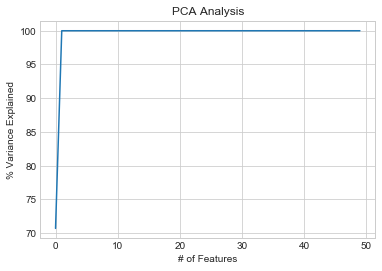

In [175]:
#Plot the PCA info
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
# plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

We see from using a 150 components PCA that the explained variance starts to plateau after 20 components; and that it does not improve much after 100 compoents (at which point percentage explained is 90%). At this point, since our classifiers are not performing very well, reducing any number of components will likely make them perform less. But,  even if they perfrom slightly less, it is worth reducing th enumber of dimensions from the current column numbers 1892 down to about 100.

In [176]:
#Use PCA to look at the explained variance by column
pca = PCA(n_components=45)
pca.fit(X_train)
pca_X_train = pca.transform(X_train)
pca_X_val = pca.transform(X_val)

#Fit logistic Regression
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
lr.fit(pca_X_train, y_train)
#Predict on training set
lr_y_pred = lr.predict(pca_X_train)
print('Logistic Training accuracy: ', accuracy_score(y_train, lr_y_pred))

#Print training classification report
print(classification_report(y_train, lr_y_pred))

#Predict validation accuracy
lr_y_pred_val = lr.predict(pca_X_val)
print('Logistic Validation accuracy: ', accuracy_score(y_val, lr_y_pred_val))

#Print validation classification report
print(classification_report(y_val, lr_y_pred_val))

Logistic Training accuracy:  0.4961063530239925


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

     Felony       0.42      0.51      0.46     53374
 Infraction       0.00      0.00      0.00       273
Misdemeanor       0.63      0.50      0.56     80917
  Violation       0.02      0.08      0.03      1812

avg / total       0.54      0.50      0.51    136376

Logistic Validation accuracy:  0.4965537468837073
             precision    recall  f1-score   support

     Felony       0.42      0.51      0.46     13314
 Infraction       0.00      0.00      0.00        69
Misdemeanor       0.63      0.50      0.56     20255
  Violation       0.02      0.09      0.03       457

avg / total       0.54      0.50      0.51     34095



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


After PCA, the accuracy did not increase or decrease much. But recall did improve slightly.